# TP1 - REDIS - Adrián José Zapater Reig.

# 3.1. Diseño de la base de datos
Se desea implementar una serie de funciones para contruir nuestra BD clave-valor que imite el funcionamiento de Twitter.
Funciones:
- nuevo_usuario
- nuevo_follower
- nuevo_following
- seguir
- nuevo_post

## Configuración

En primer lugar vamos a necesitar gestionar las propiedades de conexión. Para conectarnos a REDIS necesitamos 

In [1]:
import configparser

# Wrapper del configparser de python.
class RedisConfig(object):
    
    def __init__(self, config_file=None):
        self._config = configparser.ConfigParser()
        if config_file is not None :
            self._config.read(config_file)
    
    @property
    def host(self):
        return self._config['redis']['REDIS_HOST']
    @property
    def port(self):
        return self._config['redis']['REDIS_PORT']
    @property
    def password(self):
        return self._config['redis']['REDIS_PWD']
    @property
    def db(self):
        return self._config['redis']['REDIS_DB']
    

In [2]:
# Sustituir propiedades por las del propias de cada uno.
# En mi caso son localhost, 6379, '' y 1.
! test -f redis_config.ini && rm redis_config.ini && echo 'Se ha borrado redis_config.ini'
! touch redis_config.ini
! echo '[redis]' >> redis_config.ini
! echo 'REDIS_HOST=localhost' >> redis_config.ini
! echo 'REDIS_PORT=6379' >> redis_config.ini
! echo 'REDIS_PWD=' >> redis_config.ini
! echo 'REDIS_DB=1' >> redis_config.ini
! echo
! cat redis_config.ini
! echo
! echo 'redis_config.ini creado en: '$(pwd)

Se ha borrado redis_config.ini

[redis]
REDIS_HOST=localhost
REDIS_PORT=6379
REDIS_PWD=
REDIS_DB=1

redis_config.ini creado en: /Users/adzarei/Documents/UNED/ING_CIENC_DATOS/projects/GAI/redis/src/notebooks


In [3]:
config = RedisConfig('redis_config.ini') 
print(config.host)
print(config.port)
print(config.password)
print(config.db)

localhost
6379

1


## Redis API  \#1
Es hora de implementar los métodos que usaremos para la carga de datos:
- nuevo_usuario(username)
- nuevo_follower(username, follower, timestamp)
- nuevo_following(username, followee, timestamp)
- seguir(username, followee, timestamp)
- nuevo_post(username, body, timestamp)

In [4]:
import redis
r = redis.Redis(host=config.host, port=config.port, password=config.password, db=config.db)

In [5]:
def nuevo_usuario(username):
    if r.hget('users', username) is None:
        usr_id = r.incr('user_id')
        r.hmset('users', {username:usr_id, usr_id:username})

In [6]:
def _nuevo_follower(username, follower, timestamp):
    
    usr_id = r.hget('users', username)
    follower_id = r.hget('users', follower)
    
    if usr_id is None or follower_id is None:
        return False
    
    usr_id = usr_id.decode('utf-8')
    follower_id = follower_id.decode('utf-8')
    
    r.zadd('ts_follower_of:' + usr_id, {follower_id : timestamp})
    # TODO: check if we really need this set.
    r.sadd('follower_of:' + usr_id, follower_id)
    
    return True

In [7]:
def _nuevo_following(username, followee, timestamp):
    usr_id = r.hget('users', username)
    followee_id = r.hget('users', followee)
    
    if usr_id is None or followee_id is None:
        return
    
    usr_id = usr_id.decode('utf-8')
    followee_id = followee_id.decode('utf-8')
    
    r.zadd('ts_followee_of:' + usr_id, {followee_id : timestamp})

In [8]:
def seguir(username, followee, timestamp):
    res = _nuevo_follower(followee, username, timestamp)
    # Si el _nuevo_follower devuelve falso, no se ejecuta _nuevo_following.
    res = res and _nuevo_following(username, followee, timestamp)
    return res

In [9]:
def nuevo_post(username, body, timestamp):
    usr_id = r.hget('users', username)
    
    if usr_id is None:
        return
    
    usr_id = usr_id.decode('utf-8')
    
    post_id = r.incr('post_id')
    followers = r.smembers('follower_of:' + usr_id)

    r.hmset('post:{}'.format(post_id), {'username':username, 'body':body,  'ts':timestamp})
    
    # Guardamos la referencia para el usuario
    r.set('post_ts_usr{}_{}'.format(usr_id, post_id) , timestamp)
    r.rpush('posts_usr{}'.format(usr_id), post_id)
    
    # Guardamos la referencia para los followees del usuario.
    for follower in followers:
        follower_id = follower.decode("utf-8")
        r.set('post_ts_usr{}_{}'.format(follower_id, post_id) , timestamp)
        r.rpush('posts_usr{}'.format(follower_id), post_id)
        
        # Lista que contiene solamente los posts de tus followees.
        r.rpush('external_posts_usr{}'.format(follower_id), post_id)
        

    

# 3.2. Conjunto de datos
Se desea cargar nuestra BD con los datos alojados en los ficheros: “twitter_sample.csv” y “relations.csv”

#### twitter_sample.csv
Contiene 111 tweets.
Estructura: user, post_time y tweet_content.
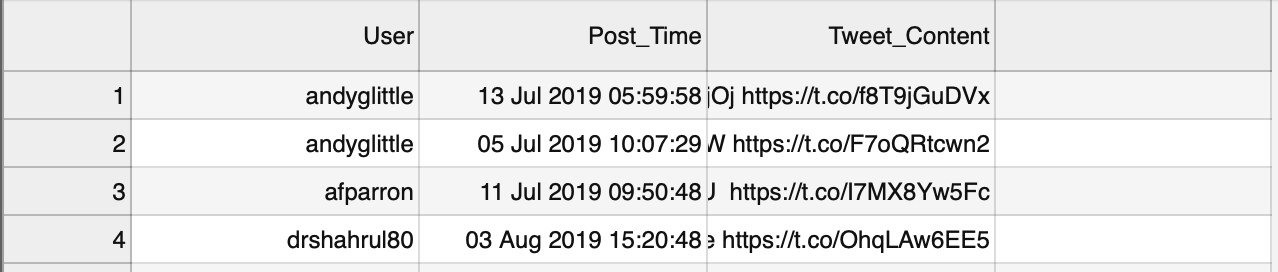


#### relations.csv
Contiene 22 relaciones.
Estructura: user, follows, following_time.
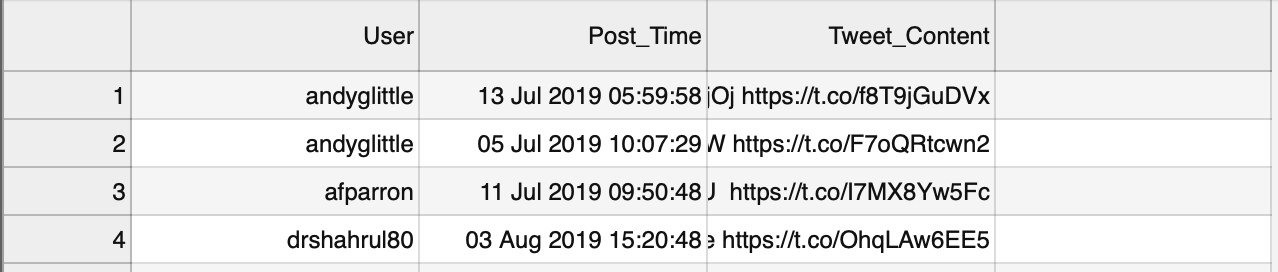



Nota: 
- En primer lugar debemos cargar topos los usuarios.
- En segundo lugar debemos cargar las relaciones
- En tercer lugar cargaremos los posts.

In [10]:
import pandas as pd
import numpy as np
import os

tweets_path = os.path.join('data','twitter_sample.csv')
relation_path = os.path.join('data','relations.csv')

tweets = pd.read_csv(filepath_or_buffer=tweets_path, header=0, sep=',', quotechar='"', encoding='utf-8')
relations = pd.read_csv(filepath_or_buffer=relation_path, header=0, sep=',', encoding='utf-8')

In [11]:
tweets.columns

Index(['User', 'Post_Time', 'Tweet_Content', 'Unnamed: 3'], dtype='object')

In [12]:
# Hay algún Nan en la columna User. Tendremos que tratarlo a parte.
tweets['User'].unique()

array(['andyglittle', 'afparron', 'drshahrul80', 'karin_stowell',
       'cathcooney', 'dkalnow', 'alkhalilkouma', 'seers_helen',
       'hanyshita', nan, 'roxanefeller', 'animalhealthEU', 'charleskod'],
      dtype=object)

In [13]:
# Hay una línea que no tiene nombre de usuario. La descartamos...
tweets[tweets['User'].isna()]

User             Post_Time  \
14  NaN  02 Jul 2019 20:56:39   

                                        Tweet_Content Unnamed: 3  
14  @stemagno74 @wcrfint @macmillancancer @NIHRres...        NaN

In [14]:
tweets.drop(index=14, inplace=True)
tweets[tweets['User'].isna()]

Empty DataFrame
Columns: [User, Post_Time, Tweet_Content, Unnamed: 3]
Index: []

In [15]:
# No tenemos Nan en Post_time.
tweets[tweets['Post_Time'].isna()]

Empty DataFrame
Columns: [User, Post_Time, Tweet_Content, Unnamed: 3]
Index: []

In [16]:
# No tenemos Nan en Tweet_Content.
tweets[tweets['Tweet_Content'].isna()]

Empty DataFrame
Columns: [User, Post_Time, Tweet_Content, Unnamed: 3]
Index: []

In [17]:
tweets.head()

User             Post_Time  \
0    andyglittle  13 Jul 2019 05:59:58   
1    andyglittle  05 Jul 2019 10:07:29   
2       afparron  11 Jul 2019 09:50:48   
3    drshahrul80  03 Aug 2019 15:20:48   
4  karin_stowell  04 Aug 2019 14:20:46   

                                       Tweet_Content Unnamed: 3  
0  We've loved being motivated by the stories of ...        NaN  
1  Thanks for the shout-out on our #MorethanMedic...        NaN  
2  #MorethanMedicine — Our Story  via ⁦@animalhea...        NaN  
3  We hope to get some lovely weather on our annu...        NaN  
4  This is what #MoreThanMedicine is about. Love ...        NaN

In [18]:
# Hay 2 líneas cuyo Tweet_Content al contener ',' y no estar envuelto por '"' se separa en una columna mas.
tweets[tweets['Unnamed: 3'].notna()]['Unnamed: 3']

19     join us on our annual sponsored 6 mile walk o...
24     environmental factors) has the possibility to...
Name: Unnamed: 3, dtype: object

In [19]:
# Cambiamos los Nan por ''.
tweets['Unnamed: 3'] = tweets['Unnamed: 3'].fillna('')

# Unimos las 2 columnas.
tweets['Tweet_Content'] = tweets['Tweet_Content'] + tweets['Unnamed: 3']

# Borramos la última columna.
tweets.drop(columns='Unnamed: 3', inplace=True)
tweets.head()

User             Post_Time  \
0    andyglittle  13 Jul 2019 05:59:58   
1    andyglittle  05 Jul 2019 10:07:29   
2       afparron  11 Jul 2019 09:50:48   
3    drshahrul80  03 Aug 2019 15:20:48   
4  karin_stowell  04 Aug 2019 14:20:46   

                                       Tweet_Content  
0  We've loved being motivated by the stories of ...  
1  Thanks for the shout-out on our #MorethanMedic...  
2  #MorethanMedicine — Our Story  via ⁦@animalhea...  
3  We hope to get some lovely weather on our annu...  
4  This is what #MoreThanMedicine is about. Love ...

In [20]:
relations.columns

Index(['User', 'Follows', 'Following_Time'], dtype='object')

In [21]:
relations.head()

User        Follows        Following_Time
0  roxanefeller     cathcooney  13 Jun 2019 05:59:58
1   andyglittle     charleskod  14 Jul 2019 10:07:29
2   andyglittle    seers_helen  18 Jul 2019 09:50:48
3   andyglittle  karin_stowell  31 Aug 2019 15:20:48
4     hanyshita    andyglittle  12 Jul 2019 14:20:46

In [22]:
users = tweets['User'].unique()
users

array(['andyglittle', 'afparron', 'drshahrul80', 'karin_stowell',
       'cathcooney', 'dkalnow', 'alkhalilkouma', 'seers_helen',
       'hanyshita', 'roxanefeller', 'animalhealthEU', 'charleskod'],
      dtype=object)

### Insertamos los usuarios

In [23]:
for user in users:
    nuevo_usuario(user)

In [24]:
r.hget('users', 'andyglittle').decode("utf-8")

'1'

In [25]:
r.hget('users', 'charleskod').decode("utf-8")

'12'

### Función para convertir de a timestamp

In [26]:
from datetime import datetime

date_format = '%d %b %Y %H:%M:%S'

def date2ts(date_string):
    return int(datetime.strptime(date_string, date_format).timestamp())
    
def ts2date(ts):
    return datetime.fromtimestamp(ts).strftime(date_format)

# Probamos la función
print(date2ts('12 Jul 2019 14:20:46'))
print(ts2date(1562934046))

1562934046
12 Jul 2019 14:20:46


### Intertamos las relaciones

In [27]:
for index, relation in relations.iterrows():
    print('user: {0} follows: {1} at: {2}'.format(relation.User, relation.Follows, date2ts(relation.Following_Time)))
    seguir(relation.User, relation.Follows, date2ts(relation.Following_Time))

user: roxanefeller follows: cathcooney at: 1560398398
user: andyglittle follows: charleskod at: 1563091649
user: andyglittle follows: seers_helen at: 1563436248
user: andyglittle follows: karin_stowell at: 1567257648
user: hanyshita follows: andyglittle at: 1562934046
user: afparron follows: animalhealthEU at: 1559361880
user: dkalnow follows: animalhealthEU at: 1561963226
user: animalhealthEU follows: drshahrul80 at: 1563541195
user: animalhealthEU follows: dkalnow at: 1566907024
user: seers_helen follows: roxanefeller at: 1572723037
user: alkhalilkouma follows: drshahrul80 at: 1564654679
user: alkhalilkouma follows: animalhealthEU at: 1562001903
user: drshahrul80 follows: afparron at: 1562100908
user: drshahrul80 follows: karin_stowell at: 1563955200
user: drshahrul80 follows: cathcooney at: 1562007399
user: cathcooney follows: alkhalilkouma at: 1561458037
user: karin_stowell follows: drshahrul80 at: 1564689505
user: charleskod follows: animalhealthEU at: 1561958878
user: charleskod 

### Cargamos los posts

In [30]:
for index, tweet in tweets.iterrows():
    print('User: {0} posted at: {1}'.format(tweet.User, tweet.Post_Time))
    nuevo_post(tweet.User, tweet.Tweet_Content, date2ts(tweet.Post_Time))

User: andyglittle posted at: 13 Jul 2019 05:59:58
User: andyglittle posted at: 05 Jul 2019 10:07:29
User: afparron posted at: 11 Jul 2019 09:50:48
User: drshahrul80 posted at: 03 Aug 2019 15:20:48
User: karin_stowell posted at: 04 Aug 2019 14:20:46
User: andyglittle posted at: 06 Jul 2019 06:04:40
User: afparron posted at: 18 Jul 2019 08:40:26
User: cathcooney posted at: 10 Jul 2019 14:59:55
User: karin_stowell posted at: 27 Jul 2019 13:57:04
User: dkalnow posted at: 02 Jul 2019 20:30:37
User: alkhalilkouma posted at: 28 Aug 2019 12:17:59
User: seers_helen posted at: 05 Jul 2019 19:25:03
User: alkhalilkouma posted at: 13 Jul 2019 22:55:08
User: hanyshita posted at: 24 Jul 2019 11:40:26
User: dkalnow posted at: 25 Jul 2019 12:20:37
User: cathcooney posted at: 10 Aug 2019 21:58:25
User: roxanefeller posted at: 04 Jul 2019 07:27:58
User: drshahrul80 posted at: 29 Jul 2019 10:11:35
User: roxanefeller posted at: 22 Aug 2019 11:37:13
User: animalhealthEU posted at: 18 Jul 2019 09:15:56
User:

# 3.3 - Pruebas
Ha llegado el momento de realizar operaciones sobre nuestra BD.

Se pide implementar 3 funciones:
- obtener_followers
- obtener_followings
- obtener_timeline

La salida exacta de obtener_timeline() será el nombre del usuario que escribió el tweet, el cuerpo del tweet y el momento de publicación (en formato fecha, no “timestamp”)

In [31]:
def obtener_followers(username):
    usr_id = r.hget('users', username).decode('utf-8')
    # Como un usuario no puede tener un follower que le ha seguido en el futuro usamos el ts de 'ahora' como limite.
    now = int(datetime.now().timestamp())
    
    followers_ts = r.zrangebyscore('ts_follower_of:' + usr_id, 0, now, withscores=True)
    
    for user_id, ts in followers_ts:
        usr = r.hget('users', user_id).decode('utf-8')
        print('{}, {}'.format(usr, ts2date(ts)))

In [32]:
obtener_followers('animalhealthEU')

afparron, 01 Jun 2019 06:04:40
charleskod, 01 Jul 2019 07:27:58
dkalnow, 01 Jul 2019 08:40:26
alkhalilkouma, 01 Jul 2019 19:25:03


In [33]:
def obtener_followings(username):
    usr_id = r.hget('users', username).decode('utf-8')
    now = int(datetime.now().timestamp())
    
    # Como un usuario no puede seguir a otro en el futuro usamos el ts de 'ahora' como limite.
    followee_ts = r.zrangebyscore('ts_followee_of:' + usr_id, 0, now, withscores=True)
    
    for user_id, ts in followee_ts:
        usr = r.hget('users', user_id).decode('utf-8')
        print('{}, {}'.format(usr, ts2date(ts)))

In [34]:
obtener_followings('animalhealthEU')

drshahrul80, 19 Jul 2019 14:59:55
dkalnow, 27 Aug 2019 13:57:04


In [35]:
def obtener_timeline(username, tweets_propios=True):
    usr_id = r.hget('users', username).decode('utf-8')
    
    if tweets_propios :
        posts = r.sort('posts_usr{}'.format(usr_id), by='post_ts_usr{}_*'.format(usr_id), desc=False)
    else:
        posts = r.sort('external_posts_usr{}'.format(usr_id), by='post_ts_usr{}_*'.format(usr_id), desc=False)
        
    for post_id in posts:
        post = r.hgetall('post:{}'.format(post_id.decode('utf-8')))
        ts = post.get(b'ts').decode('utf-8')
        body = post.get(b'body').decode('utf-8')
        owner = post.get(b'username').decode('utf-8')
        print('[{}] - {} - {}'.format(owner, body, ts))

In [36]:
obtener_timeline('animalhealthEU')

[drshahrul80] - Again-The My Special Aflac Duck that Cannes! #morethanmedicine 
Five Cannes Lions Campaigns We Liked: your winner revealed | PR Week https://t.co/6AgccDrxQg via @PRWeekUS - 1562070939
[dkalnow] - Great stats shared at our French member @SIMV_RP’s annual conference:
64 new #vaccines since 2010!
#MorethanMedicine #SantéAnimale https://t.co/HM7Mj4jF5F - 1562092237
[dkalnow] - Fantastic to be listening to 8 amazing Stage 4 cancer “thrivers” at ⁦@trewfields⁩ Festival. All of them say how important emotional and psychological self-care is along with diet, physical activity, stress management etc. We all need #morethanmedicine ⁦@PennyBrohnUK⁩ https://t.co/HdTWXV58hL - 1562526129
[dkalnow] - Today is #WorldZoonosesDay. Preventing disease in our animals also helps protect our own health. Follow @animalhealthEU’s #MorethanMedicine campaign to find out more. https://t.co/zCC3Ywq601 - 1562573139
[animalhealthEU] - To help avoid issues of social isolation requires innovative thinkin

In [37]:
obtener_timeline('animalhealthEU', tweets_propios=False)

[drshahrul80] - Again-The My Special Aflac Duck that Cannes! #morethanmedicine 
Five Cannes Lions Campaigns We Liked: your winner revealed | PR Week https://t.co/6AgccDrxQg via @PRWeekUS - 1562070939
[dkalnow] - Great stats shared at our French member @SIMV_RP’s annual conference:
64 new #vaccines since 2010!
#MorethanMedicine #SantéAnimale https://t.co/HM7Mj4jF5F - 1562092237
[dkalnow] - Fantastic to be listening to 8 amazing Stage 4 cancer “thrivers” at ⁦@trewfields⁩ Festival. All of them say how important emotional and psychological self-care is along with diet, physical activity, stress management etc. We all need #morethanmedicine ⁦@PennyBrohnUK⁩ https://t.co/HdTWXV58hL - 1562526129
[dkalnow] - Today is #WorldZoonosesDay. Preventing disease in our animals also helps protect our own health. Follow @animalhealthEU’s #MorethanMedicine campaign to find out more. https://t.co/zCC3Ywq601 - 1562573139
[drshahrul80] - SF Bay Area #cancer peeps, listen up: love &amp; parenting only become 

## Conclusiones:

En general me ha parecido un ejercicio muy interesate. He tenido muchos problemas para dejar atrás la visión relacional y abrirme a la NoSQL,aunque creo que al final he conseguido sobreponerme a este problema.

Otro problema con el que me he encontrado ha sido la documentación de la librería de python para REDIS. La documentación en general me ha parecido pobre y he tenido que recurrir a ejemplos de terceros para resolver dudas como "¿Que estructura de datos debo introducir como entity?". Es muy probable que esto se haya intensificado porque no soy programador de python y estoy acostumbrado a lenguajes de tipado estático.

Con respecto a lo que se pedía en el enunciado, la función obtener_timeline ha sido con diferencia la mas dificil. Me he encontrado con un mal diseño de BD para los posts que me ha obligado a rediseñar el modelo de datos y rehacer la mayor parte del código. Me hubiera gustado evitar duplicar la información de los posts (external_posts_usr y posts_usr), pero al no encontrar una manera de filtrar, como en una cláusula WHERE en SQL, por el id del usuario sólo se me ha ocurrido esta solución. 